## Load housing assessment and elevation data

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

assessor_df = pd.read_csv('/home/data/just_property_details.csv')

# build shapely geometries from lat, lon columns
crs = {'init': 'epsg:4326'}  # define the coordinate system
geometry = [Point(xy) for xy in zip(assessor_df.longitude, assessor_df.latitude)]
geo_df = gpd.GeoDataFrame(assessor_df, crs=crs, geometry=geometry)
# calculate an elevation column -- start by creating a point geometry column
elev_df = gpd.read_file('/contours.shp', vfs='zip:///home/data/contours.zip')

# set the CRS of the elevation if empty
if not len(elev_df.crs):
    elev_df.crs = geo_df.crs

## Perform a spatial join and do feature engineering

In [15]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np

df = gpd.sjoin(elev_df, geo_df, how='right')

# drop the no longer needed columns
del df['index_left'], df['geometry']
# rename height to elevation just for clarity
df = df.rename(columns={'height': 'elevation'})

# cleanse data formatting
# remove letters from street number
df['ST#'] =  [int(filter(lambda x: x.isdigit(), s)) for s in df['ST#']]

# make the zoning categorical variable usable by the model
zone_key = 'ZN'
label_encoder = LabelEncoder()
feature = label_encoder.fit_transform(df[zone_key])
labels = np.unique(feature)
feature = feature.reshape(len(df), 1)

# transform categorical value to a one-hot matrix
onehot_encoder = OneHotEncoder(sparse=False)
feature = onehot_encoder.fit_transform(feature)

# feed the zone OneHot matrix back into new columns
for i, lab in zip(labels, label_encoder.inverse_transform(labels)):
    new_column = '_'.join([zone_key, str(lab)])
    df[new_column] = feature[:, i].astype(bool)

## Train a model to predict the property value

In [16]:
import xgboost as xgb

# do a test/train split
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

# extract the target variable -- total property value
target_key = 'TOT'
drop_keys = {target_key, 'STREET', zone_key}
feature_keys = list(set(df.keys()) - drop_keys)

dtrain = xgb.DMatrix(train[feature_keys], label=train[target_key])
dtest = xgb.DMatrix(test[feature_keys], label=test[target_key])

# train the model -- pesos to dollars says it's a Poisson distribution
params= {'objective' : 'count:poisson',
         'eval_metric' : 'mae',
         'colsample_bytree' : 0.7,
         'eta' : 0.05,
         'max_depth' : 5,
         'num_round' : 2500}
gbm = xgb.train(params, dtrain, num_boost_round=2500, evals=[(dtest, 'eval')], early_stopping_rounds=20)

[0]	eval-mae:217518
Will train until eval-mae hasn't improved in 20 rounds.
[1]	eval-mae:217518
[2]	eval-mae:217518
[3]	eval-mae:217518
[4]	eval-mae:217518
[5]	eval-mae:217518
[6]	eval-mae:217518
[7]	eval-mae:217518
[8]	eval-mae:217518
[9]	eval-mae:217518
[10]	eval-mae:217518
[11]	eval-mae:217518
[12]	eval-mae:217518
[13]	eval-mae:217518
[14]	eval-mae:217518
[15]	eval-mae:217518
[16]	eval-mae:217518
[17]	eval-mae:217518
[18]	eval-mae:217518
[19]	eval-mae:217518
[20]	eval-mae:217518
[21]	eval-mae:217518
[22]	eval-mae:217518
[23]	eval-mae:217518
[24]	eval-mae:217518
[25]	eval-mae:217518
[26]	eval-mae:217517
[27]	eval-mae:217517
[28]	eval-mae:217517
[29]	eval-mae:217517
[30]	eval-mae:217517
[31]	eval-mae:217517
[32]	eval-mae:217517
[33]	eval-mae:217517
[34]	eval-mae:217517
[35]	eval-mae:217517
[36]	eval-mae:217517
[37]	eval-mae:217517
[38]	eval-mae:217517
[39]	eval-mae:217517
[40]	eval-mae:217517
[41]	eval-mae:217517
[42]	eval-mae:217516
[43]	eval-mae:217516
[44]	eval-mae:217516
[45]	eval

[375]	eval-mae:99595.3
[376]	eval-mae:98573.8
[377]	eval-mae:97694.9
[378]	eval-mae:96805.2
[379]	eval-mae:95791.5
[380]	eval-mae:95026.1
[381]	eval-mae:94112.6
[382]	eval-mae:93259.6
[383]	eval-mae:92390.6
[384]	eval-mae:91705.8
[385]	eval-mae:90922.9
[386]	eval-mae:90190.3
[387]	eval-mae:89518.6
[388]	eval-mae:88967
[389]	eval-mae:88373.4
[390]	eval-mae:87828.3
[391]	eval-mae:87341.6
[392]	eval-mae:86878.8
[393]	eval-mae:86439.9
[394]	eval-mae:85904.6
[395]	eval-mae:85338.8
[396]	eval-mae:84894
[397]	eval-mae:84431.9
[398]	eval-mae:83995.6
[399]	eval-mae:83495.8
[400]	eval-mae:83075.3
[401]	eval-mae:82598.2
[402]	eval-mae:82286.1
[403]	eval-mae:81866.4
[404]	eval-mae:81458.9
[405]	eval-mae:81252.2
[406]	eval-mae:80863.6
[407]	eval-mae:80528.2
[408]	eval-mae:80240.5
[409]	eval-mae:79979.4
[410]	eval-mae:79696.6
[411]	eval-mae:79383.9
[412]	eval-mae:79101
[413]	eval-mae:78844.2
[414]	eval-mae:78570.6
[415]	eval-mae:78278
[416]	eval-mae:78087.1
[417]	eval-mae:77849.4
[418]	eval-mae:7761

[735]	eval-mae:66413.5
[736]	eval-mae:66413.4
[737]	eval-mae:66377.3
[738]	eval-mae:66342.8
[739]	eval-mae:66345.2
[740]	eval-mae:66332.9
[741]	eval-mae:66327.9
[742]	eval-mae:66310.1
[743]	eval-mae:66298.9
[744]	eval-mae:66307.4
[745]	eval-mae:66288.8
[746]	eval-mae:66258.7
[747]	eval-mae:66253.5
[748]	eval-mae:66246.7
[749]	eval-mae:66245.5
[750]	eval-mae:66247.9
[751]	eval-mae:66241.5
[752]	eval-mae:66245.9
[753]	eval-mae:66229.2
[754]	eval-mae:66232.1
[755]	eval-mae:66226.5
[756]	eval-mae:66217.2
[757]	eval-mae:66217.4
[758]	eval-mae:66213.3
[759]	eval-mae:66208
[760]	eval-mae:66160.4
[761]	eval-mae:66123.6
[762]	eval-mae:66098.5
[763]	eval-mae:66099.3
[764]	eval-mae:66087.5
[765]	eval-mae:66085
[766]	eval-mae:66042.7
[767]	eval-mae:66040
[768]	eval-mae:66041.7
[769]	eval-mae:66039.1
[770]	eval-mae:66024.1
[771]	eval-mae:66015.7
[772]	eval-mae:66006.5
[773]	eval-mae:65998.2
[774]	eval-mae:65986
[775]	eval-mae:65958.3
[776]	eval-mae:65920
[777]	eval-mae:65911.2
[778]	eval-mae:65920.

[1091]	eval-mae:63596.3
[1092]	eval-mae:63590
[1093]	eval-mae:63584.2
[1094]	eval-mae:63589.9
[1095]	eval-mae:63589.9
[1096]	eval-mae:63577.9
[1097]	eval-mae:63564.6
[1098]	eval-mae:63563.2
[1099]	eval-mae:63558.2
[1100]	eval-mae:63559.9
[1101]	eval-mae:63560.4
[1102]	eval-mae:63550.5
[1103]	eval-mae:63556.5
[1104]	eval-mae:63548.9
[1105]	eval-mae:63548
[1106]	eval-mae:63551.2
[1107]	eval-mae:63543.7
[1108]	eval-mae:63542.8
[1109]	eval-mae:63528
[1110]	eval-mae:63528.8
[1111]	eval-mae:63522.9
[1112]	eval-mae:63522
[1113]	eval-mae:63503
[1114]	eval-mae:63496.2
[1115]	eval-mae:63487.7
[1116]	eval-mae:63479.3
[1117]	eval-mae:63475.3
[1118]	eval-mae:63477
[1119]	eval-mae:63469.5
[1120]	eval-mae:63463.8
[1121]	eval-mae:63465.4
[1122]	eval-mae:63455.8
[1123]	eval-mae:63464
[1124]	eval-mae:63458.7
[1125]	eval-mae:63449.2
[1126]	eval-mae:63442
[1127]	eval-mae:63443.8
[1128]	eval-mae:63437.7
[1129]	eval-mae:63435.5
[1130]	eval-mae:63430.2
[1131]	eval-mae:63434.6
[1132]	eval-mae:63425
[1133]	eva

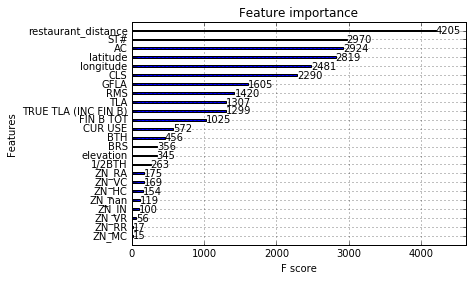

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
xgb.plot_importance(gbm)